# 1. 사전 준비

In [7]:
# 필요한 라이브러리 가져오기!!!!

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [17]:
# 로컬 방식으로 파일 업로드!!!
from google.colab import files
file_uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [18]:
# 집값 예측 자료 코랩에서 다운로드!!!
data = pd.read_csv('/content/train.csv')
sub = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

21개나 되는 feature들이 각각 어떤 의미를 갖고 있는가에 관해 간략하게 정리해 봤다.

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 집의 가격(타겟 변수이므로 중요!!)
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [19]:
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6555, 20)


In [20]:
# 타깃값인 price 칼럼 없애버고 y 변수에 따로 저장하는 과정.
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [21]:
data_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21590


In [22]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 2. 데이터 전처리

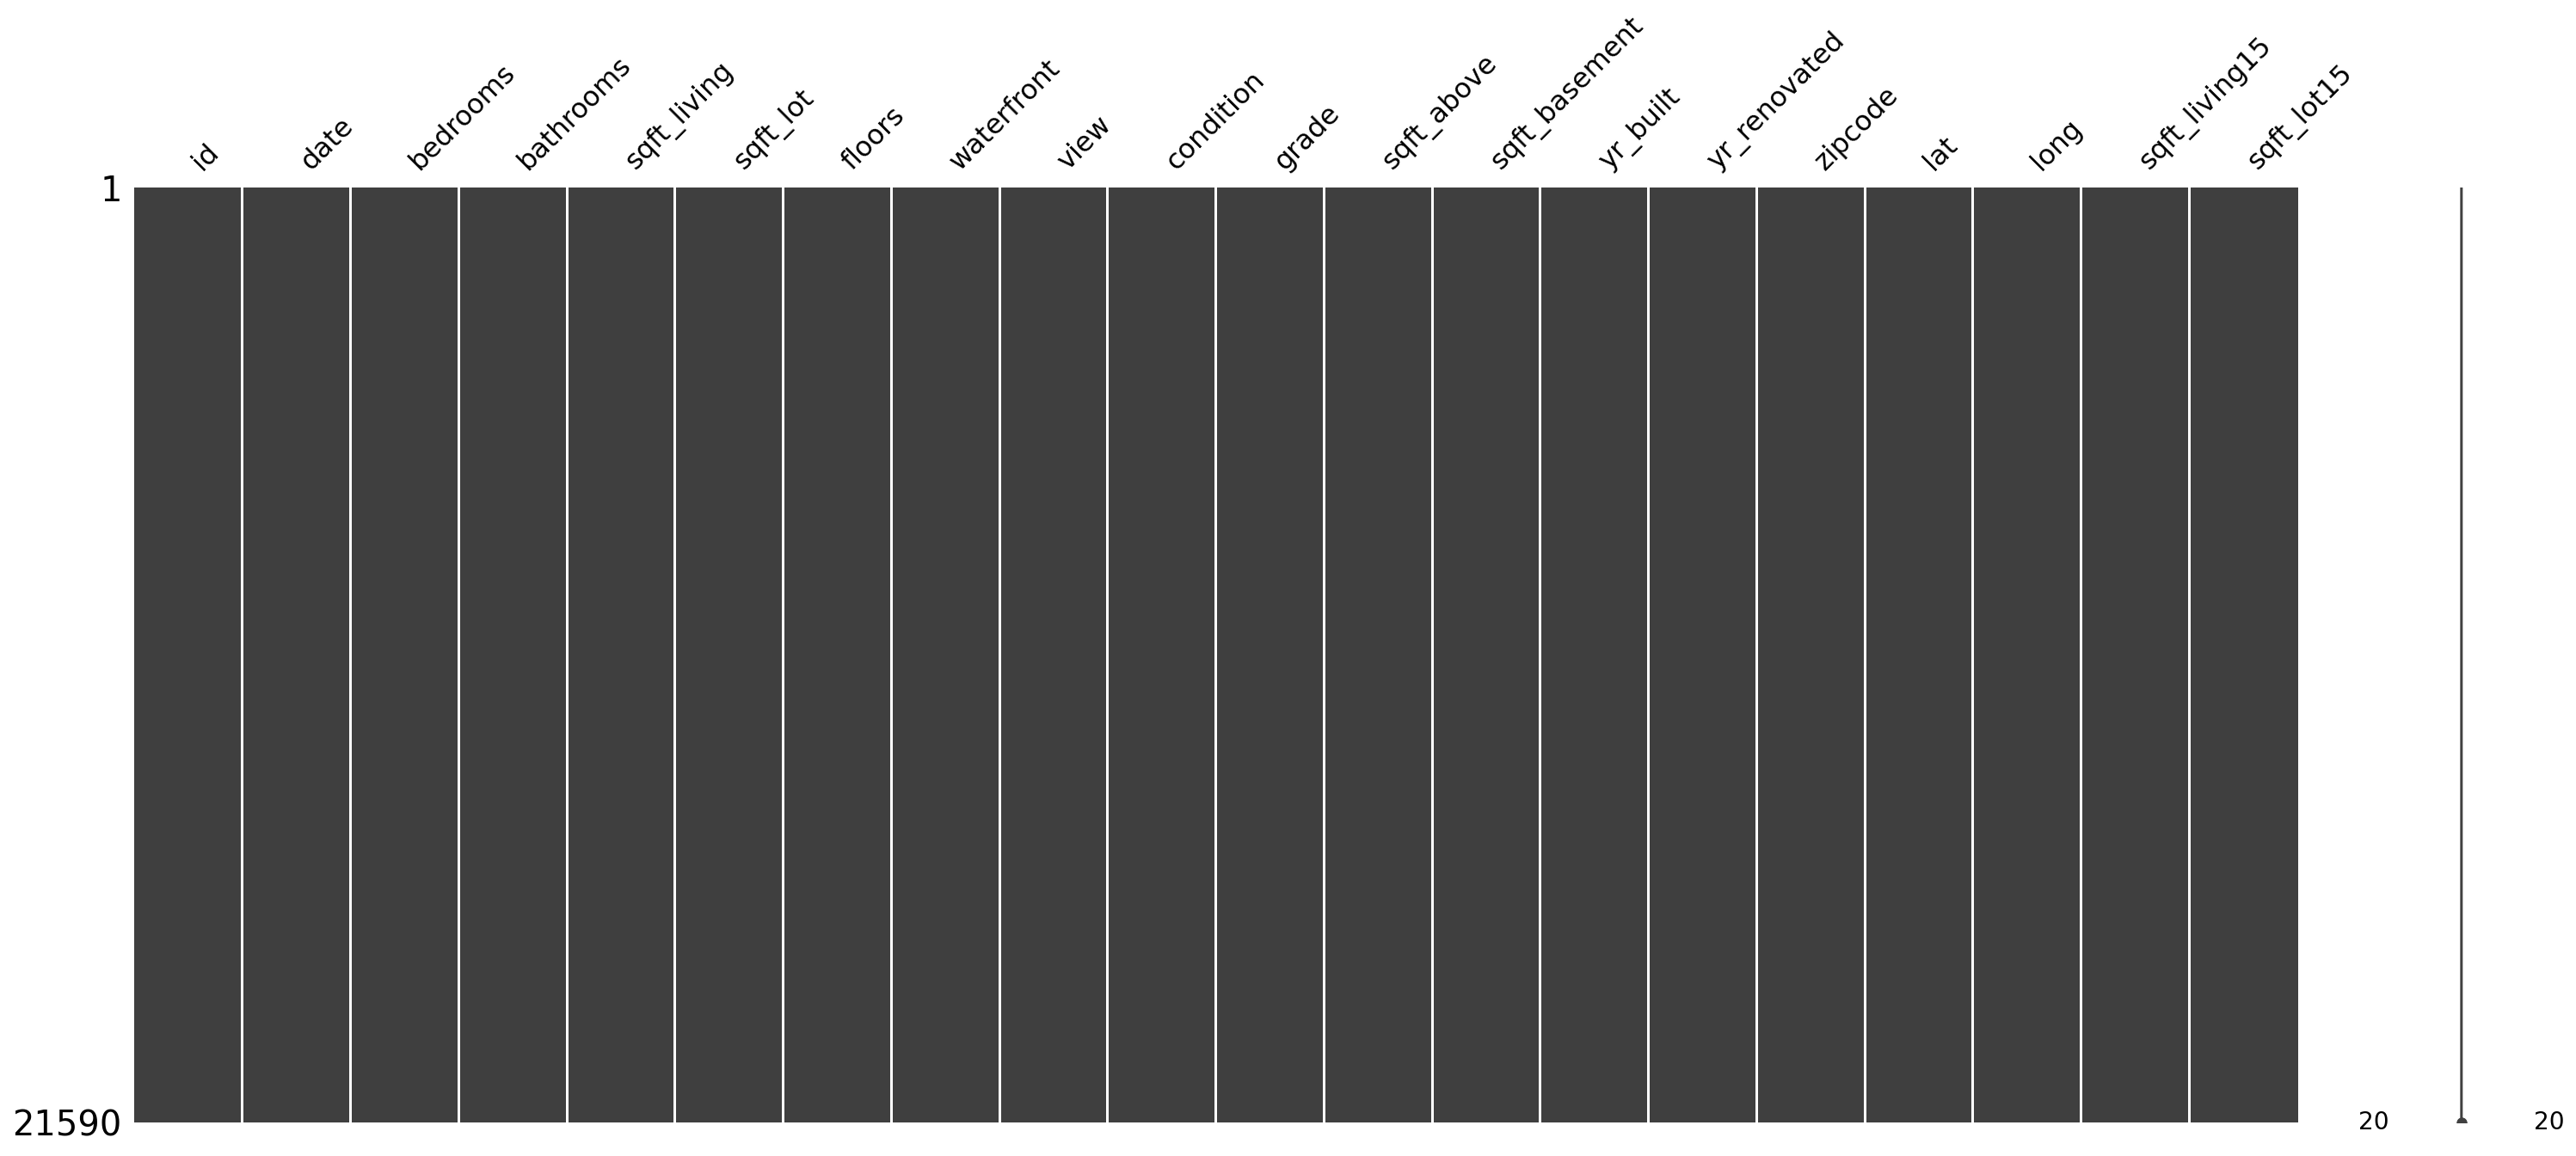

In [23]:
# 1. 타이타닉 예제 시 활용했던 missingno 라이브러리의 matrix 함수를 사용하여 결측 데이터를 시각화
msno.matrix(data)

In [24]:
# 2. id 컬럼에 결측치가 있는지 확인하는 과정.
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6550    False
6551    False
6552    False
6553    False
6554    False
Name: id, Length: 21590, dtype: bool


In [25]:
# 3. id 컬럼의 결측치인 데이터만 뽑아냅니다.
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [26]:
# 4. id 컬럼의 결측치인 데이터의 개수를 셉니다.
print('{}: {}'.format('id', len(null_data.values)))

id: 0


In [27]:
from pandas.core.frame import DataFrame
# 5. 모든 컬럼에 대해 결측치 데이터 개수 세기 적용
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


결과를 확인해 보니 모든 컬럼에 결측치가 없음을 알 수 있다.

In [28]:
sub_id = data['id'][data_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [29]:
# data 컬럼에서 apply 함수로 필요한 부분만 잘라준다.
# 앞부분 6자리 숫자(연, 월)만 필요하므로 잘라서 가져온다.
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


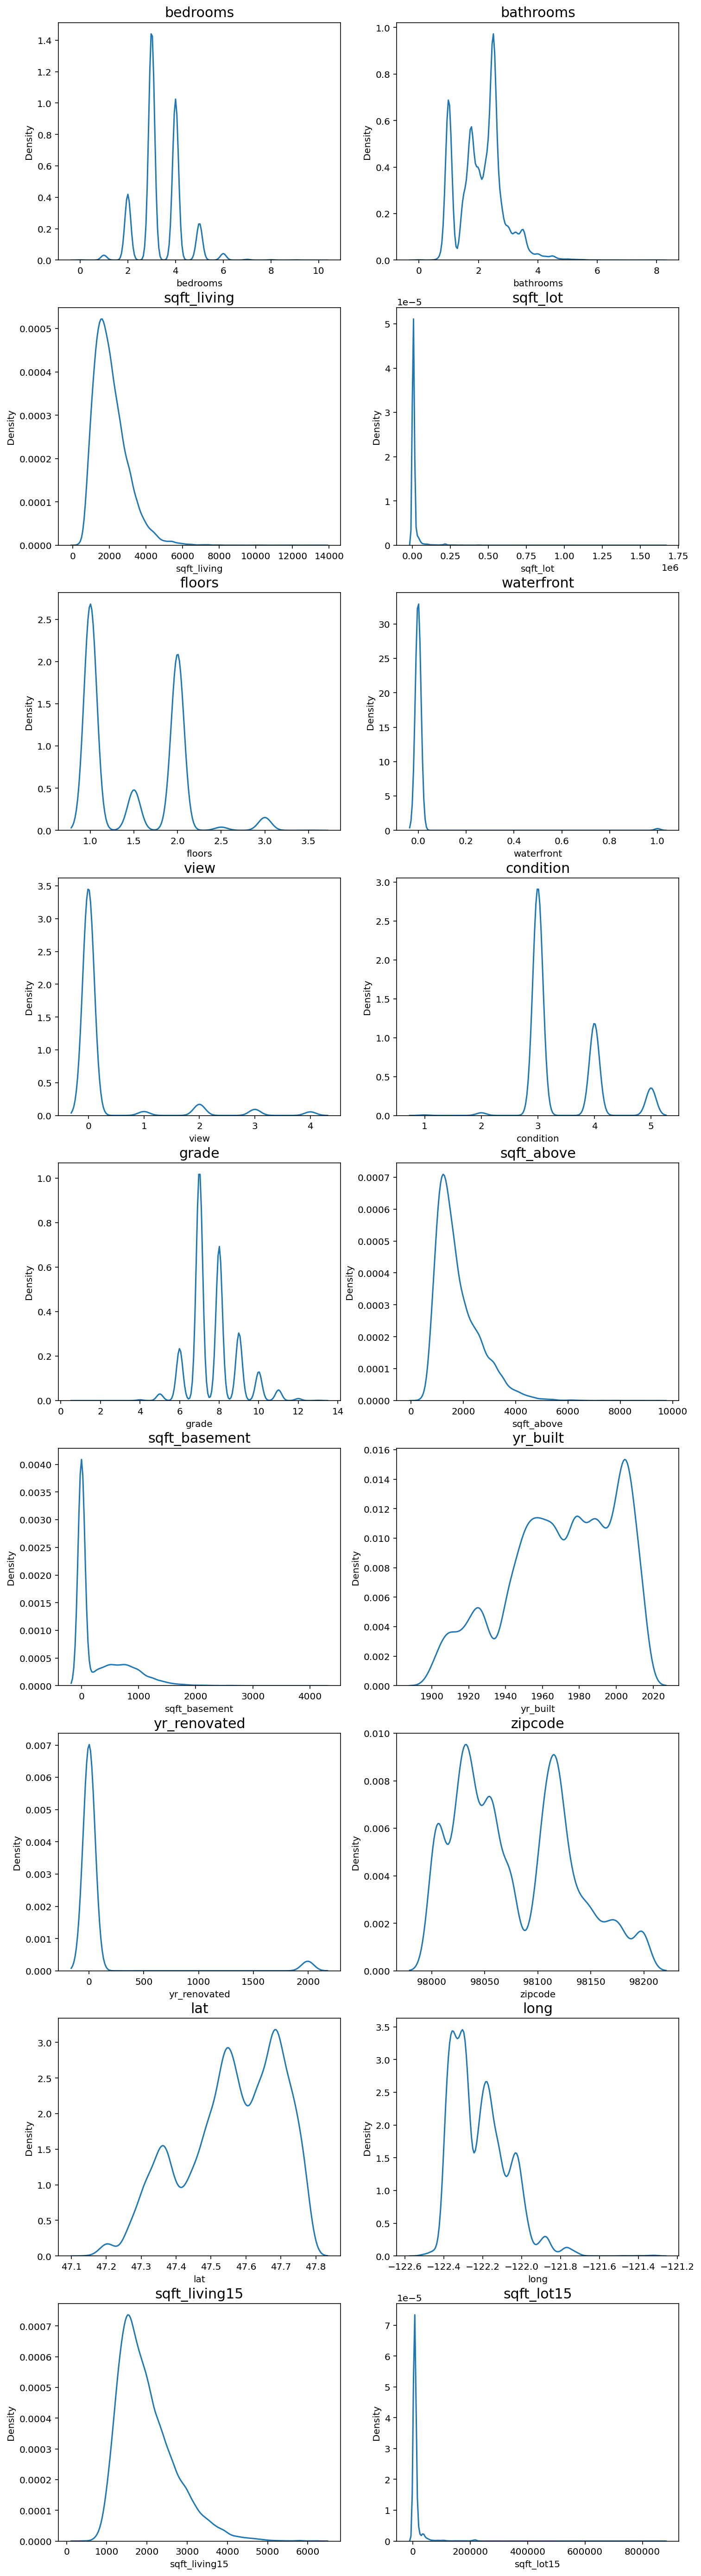

In [30]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

18가지의 feature 중 왼쪽으로 지나치게 쏠린 구간이 존재하는 그래프 개형이 보일 것이다. 이러한 그래프 개형에 대해서는 로그 변환을 하여 그래프의 치우침을 줄여보겠다.

로그 함수의 특징을 이해하면 그래프의 치우침이 줄어들고 정규분포에 가까워지는 이유를 알 수 있다. 정규화를 시킨 후 따로 설명해 보고자 한다.

In [31]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

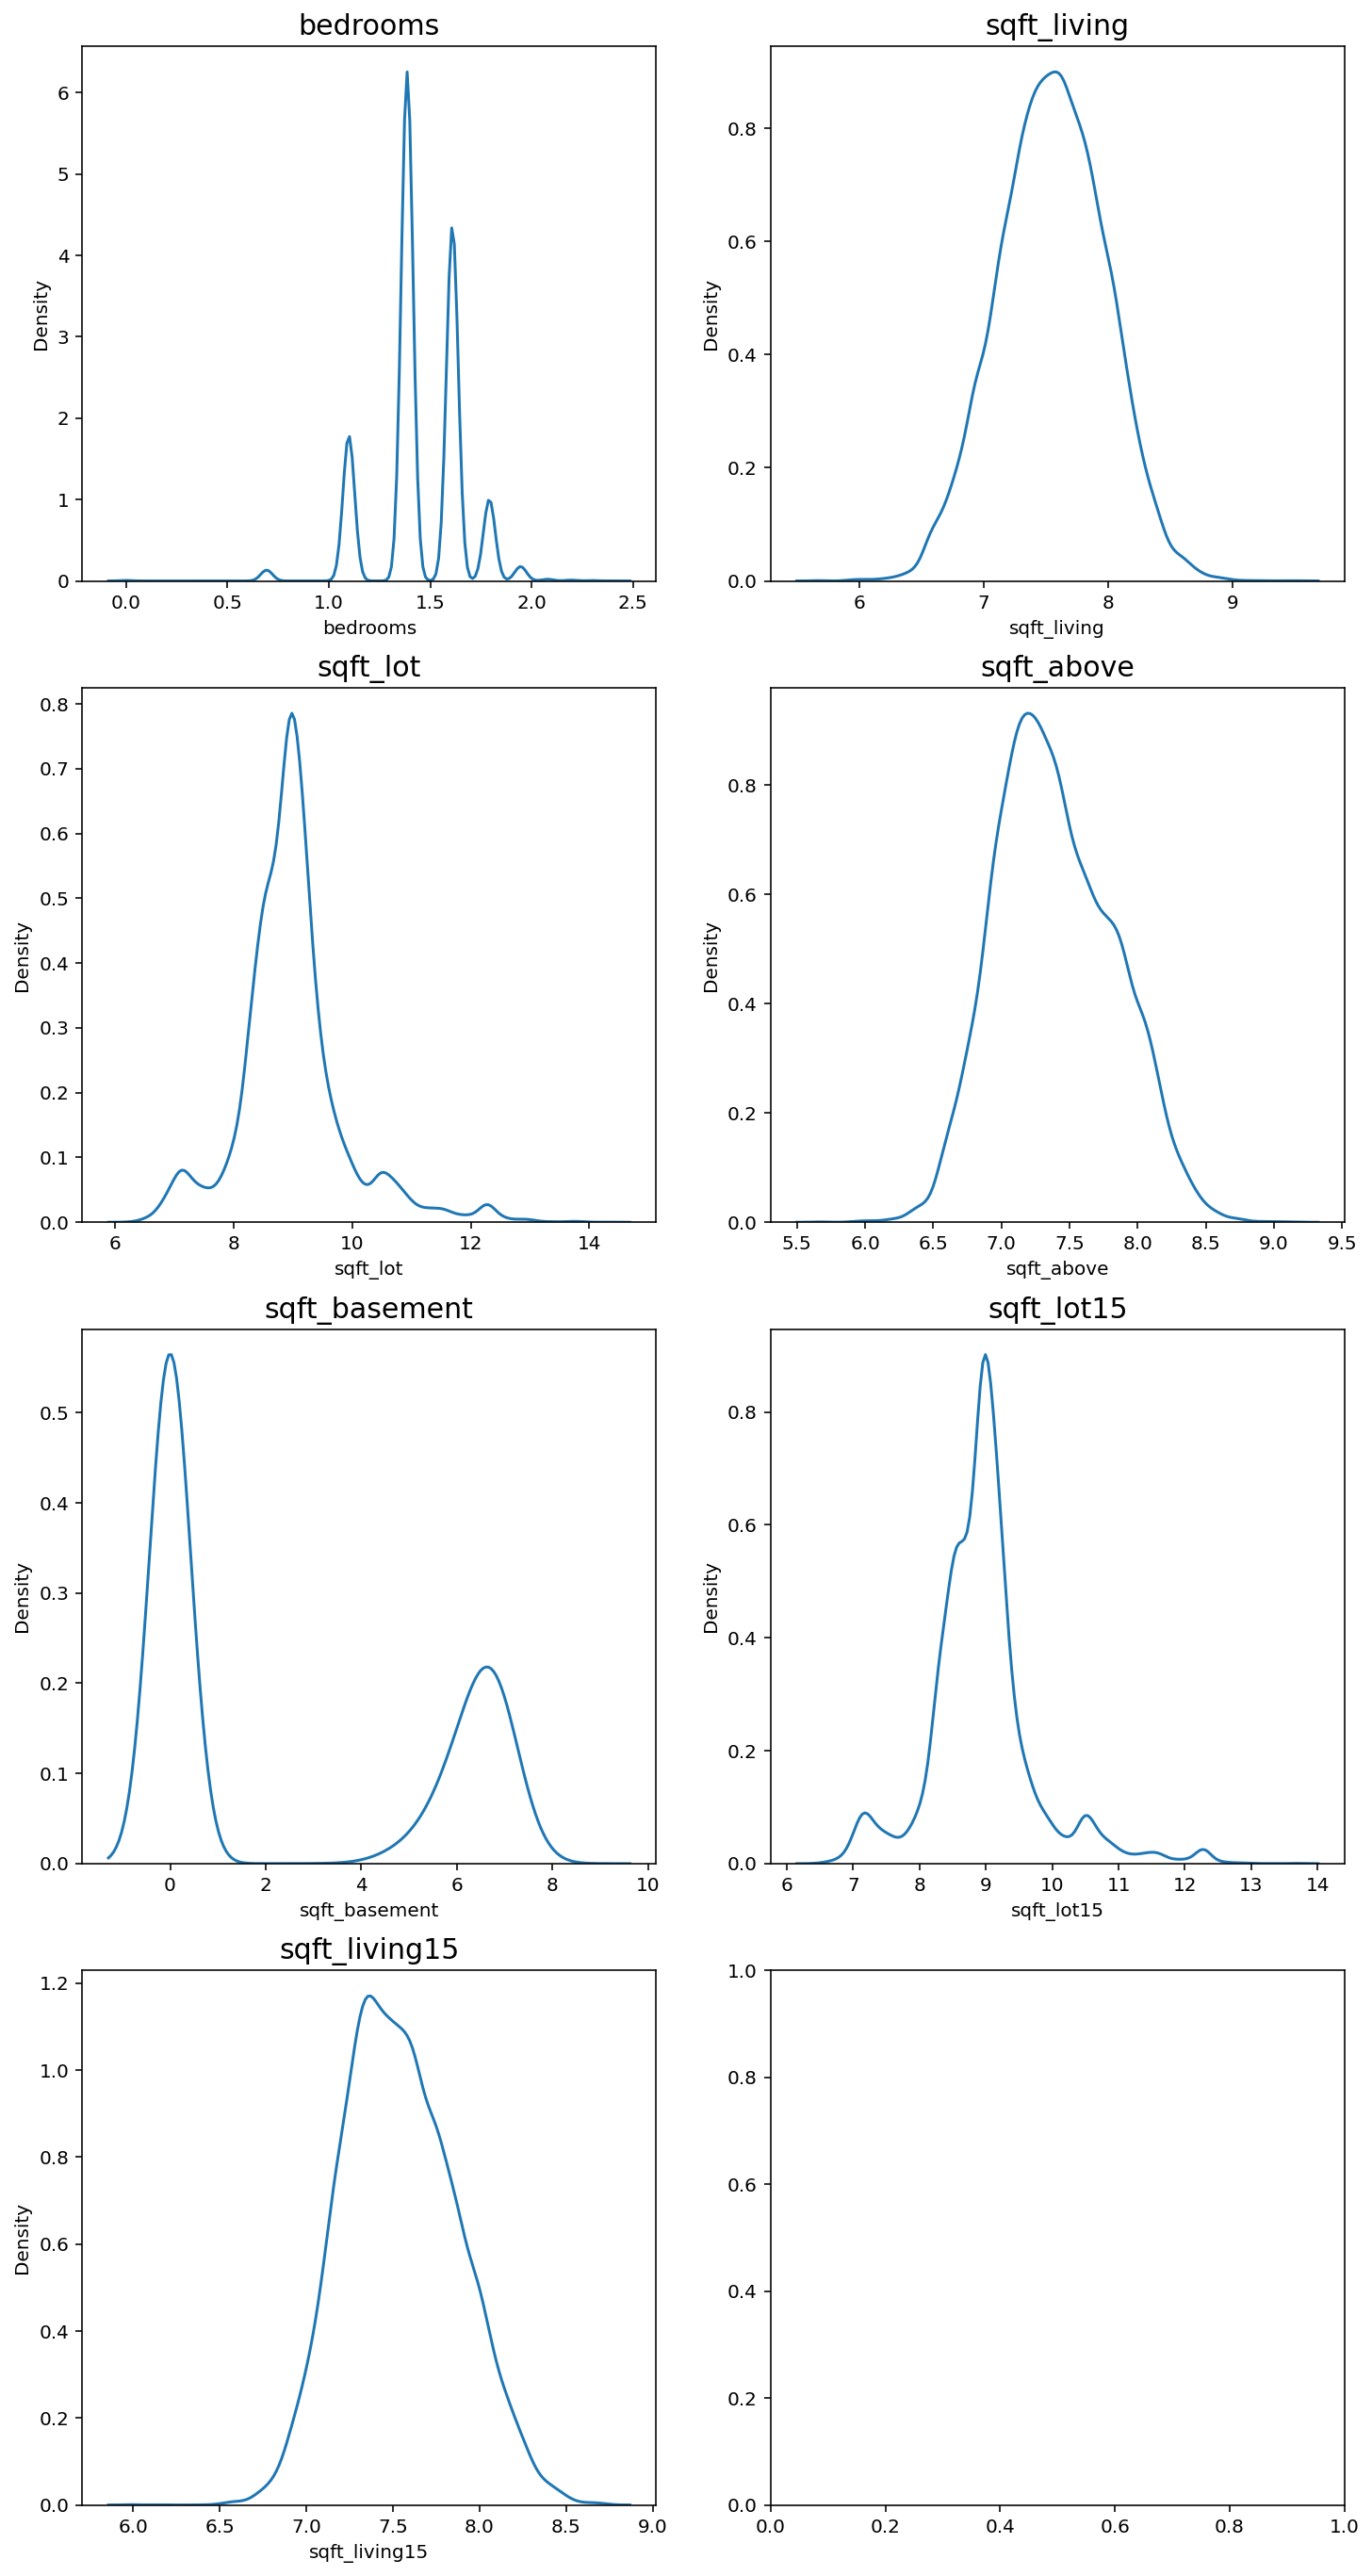

In [32]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

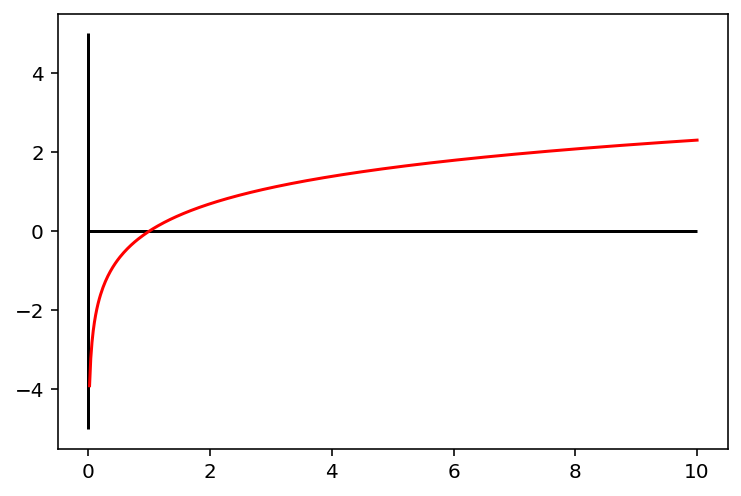

In [35]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

로그 함수의 특성은 다음과 같다.

* 0 < x < 1 범위에서는 기울기가 매우 가파르다. 즉, x의 구간은 (0, 1)(0,1)로 매우 짧은 반면, y의 구간은 (−∞,0)으로 매우 크다.

* 따라서 0에 가깝게 모여있는 값들이 x로 입력되면, 그 함수값인 y 값들은 매우 큰 범위로 벌어지게 된다. 즉, 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있는 특징을 가지게 된다.

* 반면, x값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아진다. 이는 곧 큰 x값들에 대해서는 y값이 크게 차이나지 않게 된다는 뜻이고, 따라서 넓은 범위를 가지는 x를 비교적 작은 y값의 구간 내에 모이게 하는 특징을 가진다.

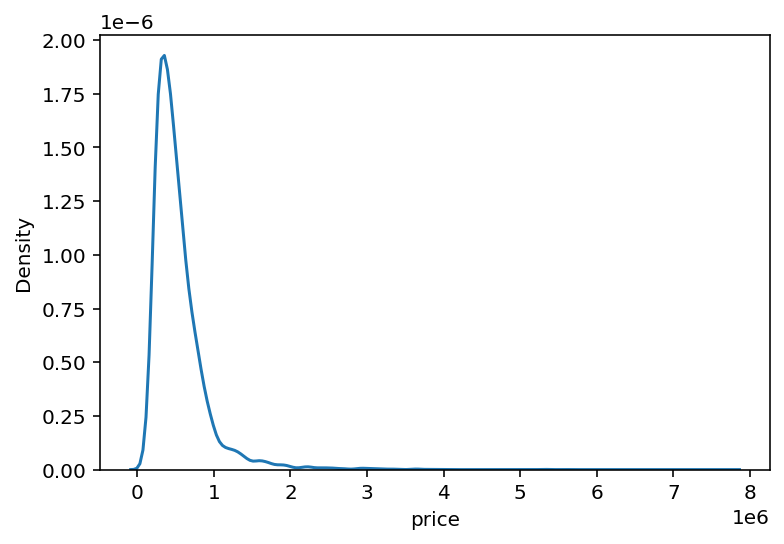

In [36]:
sns.kdeplot(y)
plt.show()

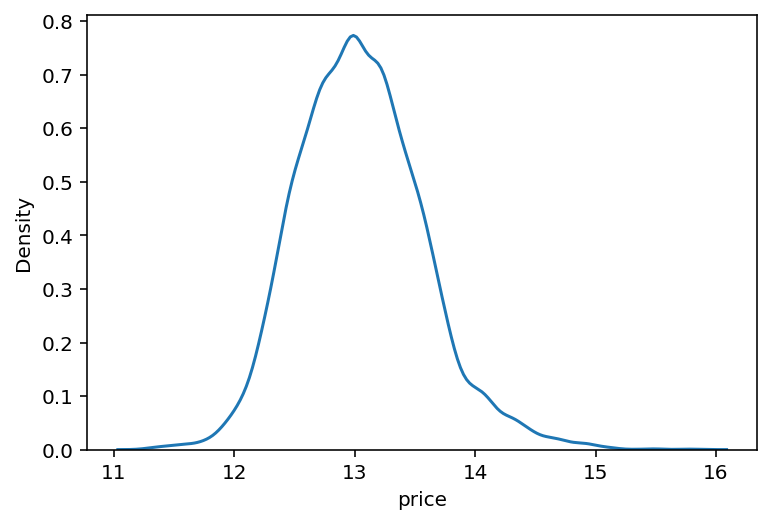

In [37]:
# 로그를 취했더니 확실히 정규분포와 가까운 형태를 띄게 되었다.
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [38]:
sub = data.iloc[data_len:, :]      # 실제로 추론을 해야 하는 테스트 데이터를 sub에 할당
x = data.iloc[:data_len, :]        # 학습 데이터는 x에 할당

print(x.shape)
print(sub.shape)

(15035, 19)
(6555, 19)


# 3. 모델 학습

In [39]:
# gbbost, xgboost, lightgbm(셋 다 부스팅 계열)의 3가지 모델을 정하는 과정.
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]


In [40]:
# 교차 검증(cross validation)
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [41]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
[01:57:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:57:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:57:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:57:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:57:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBoost, CV score:0.8624
Model: LightGBM, CV score:0.8819


* Cross_val_score() 함수는 회귀모델을 전달할 경우에 $R^2$, 즉 결정계수 값을 반환하는 기능을 하는 함수이다.  
* $R^2$ 값이 1에 가까울수록 모델이 잘 학습되었다는 것을 나타낸다.  
* 위의 3개의 트리 모델이 훈련 데이터에 대해 0.85 정도로 꽤나 괜찮은 성능을 보이는 것을 알 수 있다.
* 다음으로 각 모델에 대한 예측결과에 대한 평균치를 내주는 AveragingBlending() 함수를 만든다.

In [42]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [43]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

[01:58:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6555


array([1340643.45409443,  296685.52763961,  864489.22624638, ...,
       1793028.33080063,  411248.88690782,  345498.01852609])

위의 array 이하로 나온 값들이 바로 모델이 예측해낸 결과, 즉 price에 대한 값들이다. 아래의 코드를 통해 이 결과값을 저장하고 

In [44]:
data_dir = '/content/'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [45]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15208,1.340643e+06
1,15209,2.966855e+05
2,15210,8.644892e+05
3,15211,2.162087e+05
4,15212,4.544507e+05


In [46]:
my_submission_path = join(data_dir, 'sample_submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/content/sample_submission.csv


이 sample_submission 파일을 제출하였더니 캐글 점수가 11만 9000 정도가 나왔다. 11만 이하로 점수를 줄일 수 있는 방법을 강구하고자 다시 한번 데이터 정리를 해보고자 한다.

# 4. 점수 향상

In [47]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

In [48]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [49]:
# date 컬럼의 앞부분 6자리의 숫자만 가져옴
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [50]:
y = train['price']
del train['price']

del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


* 여기까지는 윗부분과 동일하게 타겟값인 price에 대한 컬럼을 y라는 변수로 지정해 준다. 그 다음으로는 train과 test에서 id와 같이 집값 분석에 영향을 미치지 않을 거 같은 특성들을 모두 지워버린다.  
* 필요없을 거 같은 데이터를 논리적으로 판단하고 없앨 수 있느냐하는 이러한 전처리 과정이 캐글 점수에 상당히 중요한 영향을 미칠 거 같다는 생각이 들었다.  
* 주의해야 할 것은 train에서 없앴다면 test에서도 똑같이 없애야 한다는 것이다. 이는 지난 Exploration에서 필요없는 컬럼을 제거하는 drop 과정과 상당히 유사하다는 것을 알 수 있었다.

In [51]:
# train 세트에서 거쳤던 전처리 과정을 test 세트에서도 똑같이 거친다.

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [52]:
# price가 꽤나 높은 값을 보이므로, log화(정확하게는 자연로그를 취함)를 시켜서 값을 낮춘다.
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [53]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

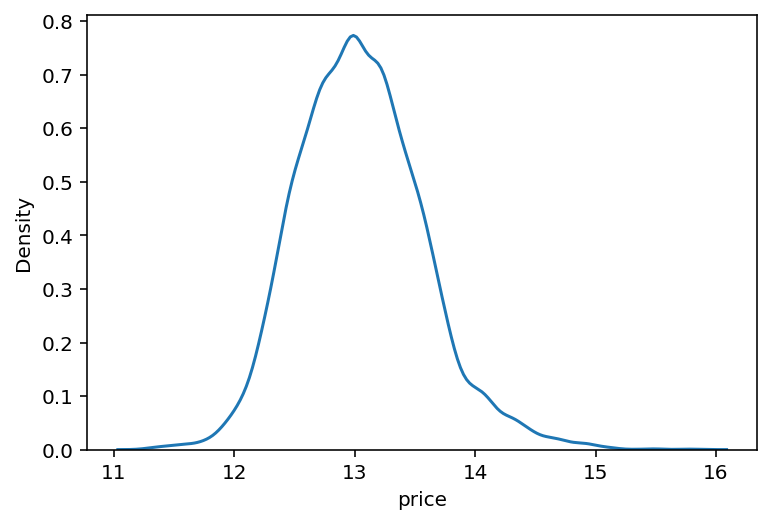

In [54]:
# 로그를 취한 후 그래프 확인. 정규분포에 가까운 형태의 그래프로 잘 나타난다.
sns.kdeplot(y)
plt.show()

In [55]:
# 모든 데이터가 실수, 정수형 자료로 문제 없이 모델 학습을 할 수 있음을 확인하였다.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [57]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [58]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [59]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택.  
random_state=2020     # 하지만 우리는 이렇게 고정값을 세팅. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [60]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [61]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

[01:58:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'GradientBoostingRegressor': 128360.19649691365,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562,
 'XGBRegressor': 131067.44622809246}

In [62]:
from sklearn.model_selection import GridSearchCV

In [63]:
# 하이퍼 파라미터에 해당하는 이 부분을 바꿔가며 여러번 돌린 끝에 목표치를 달성하는 데 성공했다.
# 바뀐 하이퍼 파라미터 값들은 아래 회고 부분 참고.
param_grid = {
    'n_estimators': [20, 2000],
    'max_depth': [1, 10],
}

In [64]:
model = LGBMRegressor(random_state=random_state)

In [65]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [20, 2000]},
             scoring='neg_mean_squared_error', verbose=1)

In [66]:
grid_model.cv_results_

{'mean_fit_time': array([ 0.20293918,  4.05731907,  0.43418212, 19.35083423]),
 'mean_score_time': array([0.01635995, 0.52399139, 0.03187919, 2.08779917]),
 'mean_test_score': array([-0.11600544, -0.03430239, -0.04287089, -0.02734511]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[20, 2000, 20, 2000],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 20},
  {'max_depth': 1, 'n_estimators': 2000},
  {'max_depth': 10, 'n_estimators': 20},
  {'max_depth': 10, 'n_estimators': 2000}],
 'rank_test_score': array([4, 2, 3, 1], dtype=int32),
 'split0_test_score': array([-0.12173765, -0.0338244 , -0.04361475, -0.02755409]),
 'split1_test_score': array([-0.11941581, -0.03577682, -0.04452749, -0.02872632]),
 'split2_test_score': array([-0.11489491, -0.03

In [67]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 20},
 {'max_depth': 1, 'n_estimators': 2000},
 {'max_depth': 10, 'n_estimators': 20},
 {'max_depth': 10, 'n_estimators': 2000}]

In [68]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.11600544, -0.03430239, -0.04287089, -0.02734511])

In [69]:
# 위의 결과값을 데이터 프레임으로 나타내는 과정
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,20,-0.116005
1,1,2000,-0.034302
2,10,20,-0.042871
3,10,2000,-0.027345


In [70]:
# 조금 전에 구한 score 값으로부터 RMSE 값을 구한 후 그 결과를 데이터 프레임에 포함시키는 과정
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,20,-0.116005,0.340596
1,1,2000,-0.034302,0.185209
2,10,20,-0.042871,0.207053
3,10,2000,-0.027345,0.165364


In [71]:
# RMSE에 해당하는 값은 실제적으로는 로그가 취해진 price 값으로부터 나온 것이기 때문에 RMSLE 값으로 정의된다.
# 따라서 RMSE는 RMSLE로 이름을 바꿔야 하며, 이 때 rename을 사용한다.
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,20,-0.116005,0.340596
1,1,2000,-0.034302,0.185209
2,10,20,-0.042871,0.207053
3,10,2000,-0.027345,0.165364


In [72]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현하는 과정.

1. GridSearchCV 모델로 `model`을 초기화.
2. 모델을 fitting.
3. params, score에 각 조합에 대한 결과를 저장. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환.
"""
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [73]:
param_grid = {
    'n_estimators': [20, 2000],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,2000,-0.027345,0.165364
1,1,2000,-0.034302,0.185209
2,10,20,-0.042871,0.207053
0,1,20,-0.116005,0.340596


In [74]:
model = LGBMRegressor(max_depth=10, n_estimators=2000, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.98077554, 12.66614392, 13.38663482, ..., 14.25599562,
       12.93051525, 12.70042611])

In [75]:
# 로그 변환했던 price에 지수변환(exponential)하여 로그 변환 이전의 원래 값으로 되돌린다.
# 이 숫자의 의미는 자연상수 e의 13.135승, 13.0805승 등등으로 계산된다.
prediction = np.expm1(prediction)
prediction

array([1179704.67564371,  316836.37882712,  651239.84905036, ...,
       1553459.55742388,  412715.10788264,  327886.58828181])

In [76]:
data_dir = '/content/'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15208,1.340643e+06
1,15209,2.966855e+05
2,15210,8.644892e+05
3,15211,2.162087e+05
4,15212,4.544507e+05


In [77]:
submission['price'] = prediction
submission.head()

,id,price
0,15208,1.179705e+06
1,15209,3.168364e+05
2,15210,6.512398e+05
3,15211,1.881333e+05
4,15212,3.900743e+05


In [78]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/content//submission_lgbm_RMSLE_0.164399.csv


# 회고

* 맨 처음 1번부터 3번까지의 과정을 LMS 내용 그대로 필사한 후 모델을 돌릴 때에는 11만 9000점.  
* 점수 향상을 위한 모델 수정 1차 수정 시도(LMS 3-9 ~ 3-13 내용 그대로 필사).  11만 5000점.  
* 하이퍼 파라미터를 조정하여 2차 수정 했더니(n_estimators : [20, 200] 및 max_depth': [1, 20]으로 변경) 11만 1000점대까지 낮추는 데 성공했다.
* 하이퍼 파라미터 변경. 3차 수정(n_estimators: [200, 2000], max_depth: [10, 200]으로 변경). 아까보다 점수가 조금 더 떨어졌다.(11만 1000점 초반대) 
* 하이퍼 파라미터 다시 한번 변경. 4차 수정(n_estimators: [20, 2000], max_depth: [1, 20]으로 변경). 목표치에 조금 더 가까워졌다!!!(11만 0656점)  
* 하이퍼 파라미터 마지막 변경. 5차 수정(n_estimators: [20, 2000], max_depth: [1, 10]). 드디어 11만점 이하 달성(109762점)!!!!

* 하이퍼 파라미터인 n_estimators와 max_depth를 조절하여 11만점 이하의 점수를 달성하고 나시 굉장히 뿌듯했다. 
* 이 Exploration을 통해 어느 부분을 개선해야 되고 하이퍼 파라미터를 어느 정도로 조절하면 원하는 목표치에 수렴할 수 있는지에 대한 감을 확실히 잡을 수 있었던 유익한 시간이었다.
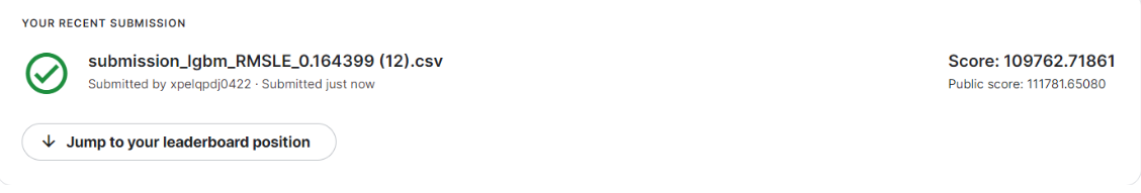

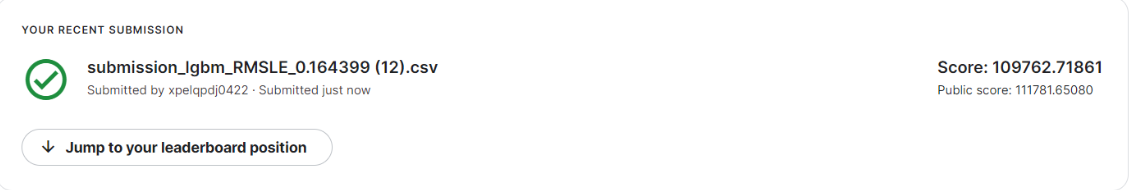